### Correct C1 precip using increases in SWE

Change C1 precip to only increase when SWE increases during the snow season. 

Meromy, L., Molotch, N. P., Williams, M. W., Musselman, K. N. and Kueppers, L. M.: Snowpack-climate manipulation using infrared heaters in subalpine forests of the Southern Rocky Mountains, USA, Agricultural and Forest  …, 203, 142–157, doi:10.1016/j.agrformet.2014.12.015, 2015.

In [7]:
import datetime as time

In [1]:
c1 = pd.read_pickle('./data/c1_met_jennings_QAQC.pcl')

In [2]:
strt = c1.index.min()
nd = c1.index.max()

In [3]:
swe = pd.read_pickle('../data/niwot_new.pcl')[strt:nd]

In [49]:
nwt = pd.read_pickle('../data/niwot_stats.pcl')

In [8]:
# generate an change in SWE variable
swe['deltaSWE'] = 0.
dt = time.timedelta(1)

for day in swe.index[1:]:
    swe.loc[day,'deltaSWE'] = swe.loc[day,'SWE']-swe.loc[day-dt,'SWE']

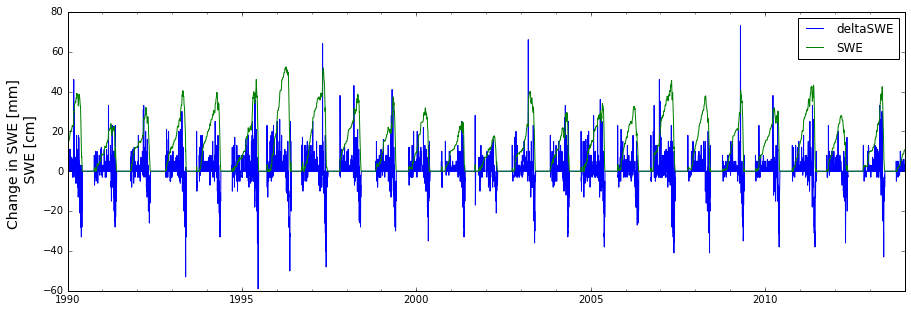

In [14]:
swe.deltaSWE.plot(figsize=(15,5))
(swe.SWE/10.).plot()
plt.ylabel('Change in SWE [mm] \n SWE [cm]', fontsize=14)
plt.legend()

In [15]:
swe['snowfall'] = swe.deltaSWE.copy()

In [16]:
c1['wateryear'] = c1.index.map(rut.wateryear)

In [31]:
swe.loc[swe.snowfall<0,'snowfall'] = 0
swe.snowfall /= 1000. # mm > m

In [51]:
swe['wateryear'] = swe.index.map(rut.wateryear)

In [53]:
winter_snowfall = swe.groupby(by='wateryear').sum()['snowfall']

In [64]:
nwt.loc[nwt.index==1982].DateNS.as_matrix()[0]

Timestamp('1982-06-11 00:00:00')

In [66]:
winter_P = []

for year in c1.wateryear.unique():
    
    strt = nwt.loc[nwt.index==year].accumSeasDate.as_matrix()[0]
    nd = nwt.loc[nwt.index==year].DateNS.as_matrix()[0]
    
    tmp = c1[strt:nd]
    winter_P.append(tmp['P'].sum())

In [76]:
comp = pd.DataFrame({'sweP':winter_snowfall,'winterP':winter_P})

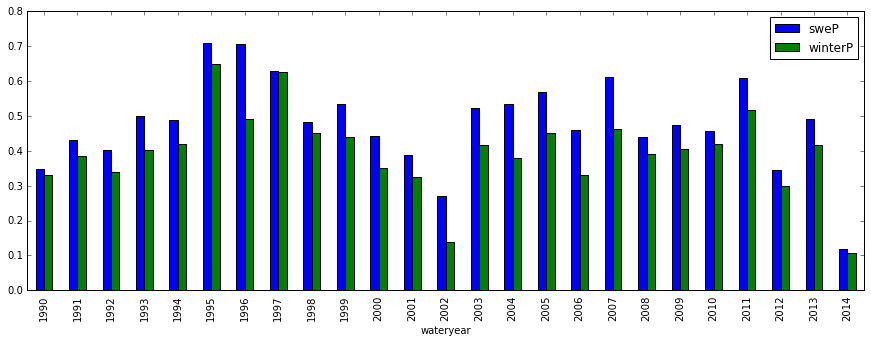

In [77]:
comp.plot.bar(figsize=(15,5))

In [91]:
comp['coef'] = comp.sweP/comp.winterP

In [92]:
c1['corrP'] = 0

for year in c1.wateryear.unique():
    c1.loc[c1.wateryear==year,'corrP'] = c1.loc[c1.wateryear==year,'P']*comp.loc[comp.index==year,'coef'].as_matrix()

In [102]:
c1.head()

,Tmin,Tmax,Tave,P,rain_duration,wind,wateryear,corrP,Pdiff
datetime,,,,,,,,,
1990-01-01,-10.13,3.349,-3.769435,0.000,0.0000,3.669174,1990,0.000000,0.000000
1990-01-02,-9.32,0.768,-4.295208,0.005,4.5276,2.502083,1990,0.005288,-0.000288
1990-01-03,-17.01,-5.561,-11.571542,0.000,0.0000,2.622417,1990,0.000000,0.000000
1990-01-04,-13.21,-4.252,-10.488625,0.000,0.0000,4.540167,1990,0.000000,0.000000
1990-01-05,-12.69,-1.410,-8.320833,0.000,0.0000,4.722458,1990,0.000000,0.000000


In [103]:
c1.to_pickle('./data/c1_met_jennings_QAQC_corrP.pcl')

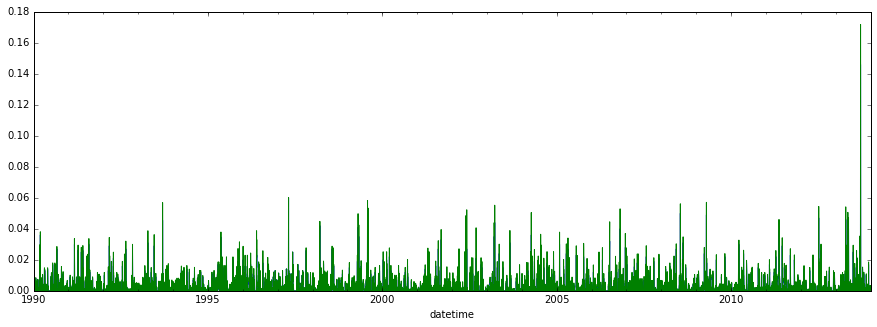

In [93]:
c1.P.plot(figsize=(15,5))
c1.corrP.plot(c='g')

In [94]:
summary = pd.DataFrame({'P':c1.groupby(by='wateryear').sum()['P'],
                        'corrP':c1.groupby(by='wateryear').sum()['corrP']},
                       index=c1.wateryear.unique())

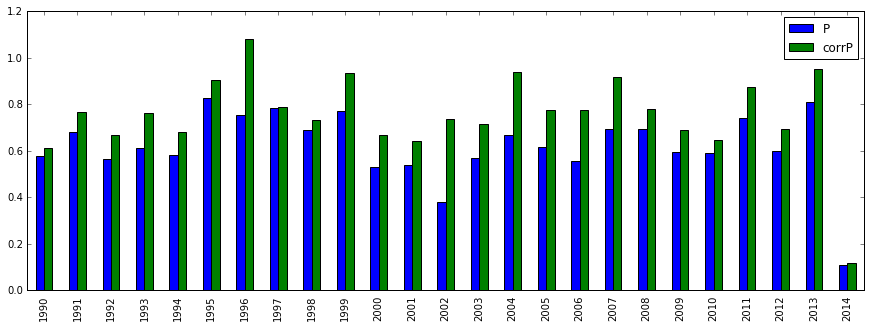

In [95]:
summary.plot(kind='bar',figsize=(15,5))

In [96]:
c1['Pdiff'] = c1.P - c1.corrP

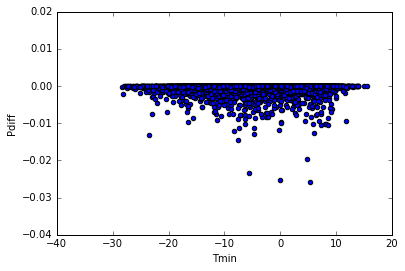

In [101]:
c1.plot.scatter('Tmin','Pdiff')